# ENCODER DECODER MODEL FOR CHARACTER LEVEL EMBEDDING 

In [ ]:
## LOADING THE REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import tensorflow as tf
from  tensorflow.keras.preprocessing.sequence import pad_sequences
from  sklearn.model_selection import train_test_split

## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## LOADING THE PROCESSED DATASET 

df= pd.read_csv("/content/drive/MyDrive/ColabNotebooks/cs2/processed_data.csv")
df.columns = ["enc_input","dec_input","y"] 
df["dec_output"] = df.dec_input
df

,enc_input,dec_input,y,dec_output
0,and he took in my favorite subject like soccer,and he took in my favorite subjects like soccer,1,and he took in my favorite subjects like soccer
1,actually who let me know about lang 8 was him,actually he was the one who let me know about ...,1,actually he was the one who let me know about ...
2,his kanji is ability is much better than me,his kanji ability is much better than mine,1,his kanji ability is much better than mine
3,we have known each other for only half a year ...,we have known each other for only half a year ...,1,we have known each other for only half a year ...
4,i heard a sentence last night when i watched tv,i heard a sentence last night when i was watch...,1,i heard a sentence last night when i was watch...
...,...,...,...,...
505893,hmmm thk i usually book on wkends depends la,hmm i think i usually book on weekends it depends,2,hmm i think i usually book on weekends it depends
505894,ask them got any sms messages to gif me leinow...,can you ask them whether they have for any sms...,2,can you ask them whether they have for any sms...
505895,we r near coca oredi,we are near coca already,2,we are near coca already
505896,hall eleven got lectures le mahn forget abt co...,hall eleven got lectures and forget about comp...,2,hall eleven got lectures and forget about comp...


## Adding start and end token

In [ ]:
## THE INPUTS TO THE DECODER REQUIRES SPECIAL TOKENS FOR THE START AND THE END SO WE ARE GOING TO USE 
## <start> AS BEGINING TOKEN
## <end>  AS END TOKEN

df["dec_input"]= "< " + df["dec_input"]
df["dec_output"] =  df["dec_output"] + " >" 
df

,enc_input,dec_input,y,dec_output
0,and he took in my favorite subject like soccer,< and he took in my favorite subjects like soccer,1,and he took in my favorite subjects like soccer >
1,actually who let me know about lang 8 was him,< actually he was the one who let me know abou...,1,actually he was the one who let me know about ...
2,his kanji is ability is much better than me,< his kanji ability is much better than mine,1,his kanji ability is much better than mine >
3,we have known each other for only half a year ...,< we have known each other for only half a yea...,1,we have known each other for only half a year ...
4,i heard a sentence last night when i watched tv,< i heard a sentence last night when i was wat...,1,i heard a sentence last night when i was watch...
...,...,...,...,...
505893,hmmm thk i usually book on wkends depends la,< hmm i think i usually book on weekends it de...,2,hmm i think i usually book on weekends it depe...
505894,ask them got any sms messages to gif me leinow...,< can you ask them whether they have for any s...,2,can you ask them whether they have for any sms...
505895,we r near coca oredi,< we are near coca already,2,we are near coca already >
505896,hall eleven got lectures le mahn forget abt co...,< hall eleven got lectures and forget about co...,2,hall eleven got lectures and forget about comp...


## SPLITTING ANJ SAMPLITNG AROUD 100K DATAPOINTS


---
##### THE TOTAL DATASET HAS 500K DATAPOINTS WHICH WILL TAKE MUCH HIGHER TRAINING TIME. THEREFORE I AM SAMPLING ONE-FIFTH OF THE TOTAL DATASET


In [ ]:
df_sampled = pd.concat((df[df.y==1].sample(frac= 0.2,random_state=1),df[df.y==2]))

In [ ]:
## ONCE THE DATA IS SAMPLED WE ARE SPLITTIND THE DATA IN TO TRAIN AND TEST
df_train ,df_val = train_test_split(df_sampled,test_size=0.2,random_state = 3, stratify = df_sampled.y )

In [ ]:
## IN THE COLUMN WHICH HAS DECODER INPUTS ADDING "<end>" TOKEN TO BE LEARNED BY THE TOKENIZER
df_train["dec_input"].iloc[0]  = df_train.iloc[0]["dec_input"] + " >"
df_train

,enc_input,dec_input,y,dec_output
104937,my older brother work in company,< my older brother works for a company >,1,my older brother works for a company >
135435,the price of tokyo sky tree is observation deck,< the price of admission to the tokyo sky tree...,1,the price of admission to the tokyo sky tree i...
501359,i am afraid of taking a job now a days,< i am afraid of getting job a now days,1,i am afraid of getting job a now days >
407321,it is too way short but that is all for this m...,< it is way too short but that is all for this...,1,it is way too short but that is all for this m...
296037,i really like these sports because the uniform...,< i really like these sports because their uni...,1,i really like these sports because their unifo...
...,...,...,...,...
492361,i decided to go to america in this august,< i decided to go to america this august,1,i decided to go to america this august >
86561,my daughter was quite nervous to start with bu...,< my daughter was quite nervous at the start b...,1,my daughter was quite nervous at the start but...
48899,omg it is crawling out i thought to myself,< omg it is crawling out i thought to myself,1,omg it is crawling out i thought to myself >
218985,skip beat with spanish subtitle,< skip beat with spanish subtitles,1,skip beat with spanish subtitles >


In [ ]:
## VALIDATION DATA
df_val

,enc_input,dec_input,y,dec_output
71342,in the last stage add the mixture of potato an...,< in the last stage add the mixture of potato ...,1,in the last stage add the mixture of potato an...
395034,of course the experiences of japanese are also...,< of course the experiences of the japanese ar...,1,of course the experiences of the japanese are ...
208880,but watching other is play gives me many stimu...,< but watching others play is exciting after all,1,but watching others play is exciting after all >
198826,and this is my new tattoos,< and these are my new tattoos,1,and these are my new tattoos >
313016,i write a diary in english for the first time,< i am writing a diary in english for the firs...,1,i am writing a diary in english for the first ...
...,...,...,...,...
247300,i love family,< i love my family,1,i love my family >
505055,ok i going soon and also send xyan home at the...,< ok i am going soon and also send xyan home a...,2,ok i am going soon and also send xyan home at ...
126924,house car people had been washed away by the b...,< houses cars and people had been washed away ...,1,houses cars and people had been washed away by...
53162,on the weekend i had to go back to my home to ...,< on the weekend i had to go back to my home t...,1,on the weekend i had to go back to my home to ...


In [ ]:
## HERE I AM SAMPLING 1000 POINTS FROM THE DATAFRAME AS TEST DATA WHICH ARE NOT PRESEENT IN THE TRAIN AND VALIDAION DATA
np.random.seed(5)
df_test = df.loc[np.random.choice(np.array([x for x in df.index.values if x not in df_sampled.index.values]),1000,replace= False,)]
df_test

,enc_input,dec_input,y,dec_output
144583,you are meeting your friends and going to a ba...,< you are meeting your friends and going to a ...,1,you are meeting your friends and going to a ba...
455599,but since i got here i have not studied a lot,< but since i got here i have not studied ver...,1,but since i got here i have not studied very ...
13922,we had lunch with them in a house flooded by t...,< we had lunch with those whose house had been...,1,we had lunch with those whose house had been f...
128968,an professor introduced me to her,< a professor introduced me to her,1,a professor introduced me to her >
402800,his companions were having drinks in front of ...,< his companions were having drinks in front o...,1,his companions were having drinks in front of ...
...,...,...,...,...
352632,so many people is suffuring from hunger povert...,< so many people are suffering from hunger and...,1,so many people are suffering from hunger and p...
191449,i wish i could be of some help during this big...,< i hope to offer some help in this big change...,1,i hope to offer some help in this big change b...
179722,anyway what i hope is he will come to shanghai...,< anyway what i hope is that he will come to s...,1,anyway what i hope is that he will come to sha...
38604,i just saw something on the facebook,< i just saw something on facebook,1,i just saw something on facebook >


## Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
## TOKENIZER FOR ENCODER INPUT
tk_inp = Tokenizer(char_level=True )
tk_inp.fit_on_texts(df_train.enc_input.apply(str))

In [ ]:
# TOKENIZER FOR DECODER INPUT
tk_out = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' , char_level=True)
tk_out.fit_on_texts(df_train.dec_input.apply(str))

## Dataset

In [ ]:
## THIS CLASS CONVERTS TEXT DATA TO INTEGER SEQUENCES AND RETURNS THE PADDED SEQUENCES
class Dataset :
    def __init__(self, data , tk_inp ,tk_out, max_len):
        self.encoder_inp = data["enc_input"].apply(str).values
        self.decoder_inp = data["dec_input"].apply(str).values
        self.decoder_out = data["dec_output"].apply(str).values
        self.tk_inp = tk_inp
        self.tk_out = tk_out
        self.max_len = max_len
      
        
    def __getitem__(self,i):
        # INPUT SEQUENCES
        encoder_seq = self.tk_inp.texts_to_sequences([self.encoder_inp[i]])
        # DECODER INPUT SEQUENCES 
        decoder_inp_seq = self.tk_out.texts_to_sequences([self.decoder_inp[i]])
        # DECODER INPUT SEQUENCES
        decoder_out_seq = self.tk_out.texts_to_sequences([self.decoder_out[i]])
        
        # PADDING THE ENCODER INPUT SEQUENCES
        encoder_seq = pad_sequences(encoder_seq, padding="post",maxlen = self.max_len)
        # PADDING THE DECODER INPUT SEQUENCES
        decoder_inp_seq = pad_sequences(decoder_inp_seq,  padding="post",maxlen = self.max_len)
        # PADDING DECODER OUTPUT SEQUENCES
        decoder_out_seq = pad_sequences(decoder_out_seq ,  padding="post",maxlen = self.max_len)

        ## ONE HOT ENCODING INPUT SEQUENCES
        encoder_seq = tf.one_hot(encoder_seq, depth= len(self.tk_inp.word_index)+1 , axis=-1 )
        ## ONE HOT ENCODING DECODER INPUT SEQUENCES
        decoder_inp_seq = tf.one_hot(decoder_inp_seq, depth= len(self.tk_out.word_index)+1 , axis=-1 )
        ## ONE HOT ENCODING DECODER INPUT SEQUENCES
        decoder_out_seq = tf.one_hot(decoder_out_seq, depth= len(self.tk_out.word_index)+1, axis=-1 )
        return encoder_seq ,  decoder_inp_seq,  decoder_out_seq
    
    def __len__(self):
        # RETURN THE LEN OF INPUT ENDODER
        return len(self.encoder_inp)

In [ ]:
## THIS CLASS CONVERTES THE DATASET INTO THE REQUIRED BATCH SIZE

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self,batch_size,dataset):
        # INTIALIZING THE REQUIRED VARIABLES 
        self.dataset = dataset
        self.batch_size = batch_size
        self.totl_points = self.dataset.encoder_inp.shape[0]
        
    def __getitem__(self,i):
        # STATING THE START AND STOP VATIABLE CONTAINGING INDEX VALUES FOR EACH BATCH
        start = i * self.batch_size
        stop = (i+1)*self.batch_size
        
        # PLACEHOLDERS FOR BATCHED DATA
        batch_enc =[]
        batch_dec_input = []
        batch_dec_out =[]

        for j in range(start,stop): 
            
            a,b,c = self.dataset[j] 
            batch_enc.append(a[0]) 
            batch_dec_input.append(b[0])
            batch_dec_out.append(c[0]) 
        
        # Conveting list to array   
        batch_enc = (np.array(batch_enc)) 
        batch_dec_input = np.array(batch_dec_input)
        batch_dec_out = np.array(batch_dec_out)
         ## RETURNING BATCHED DATA IN REQUIRED FORM
        return [batch_enc , batch_dec_input],batch_dec_out
    
    def __len__(self):
        # Returning the number of batches
        return int(self.totl_points/self.batch_size)

###### WE ARE TAKING THE MAXIMUM LENGHT EQUAL TO 180 WHICH IS 99 PERCENTILE OF THE DISTRUBUTION OF CHARACTER LENGTH.

In [ ]:
# FORMING OBJECTS OF DATASET AND DATALOADER FOR TRAIN DATASET
train_dataset = Dataset(df_train,tk_inp,tk_out,180)
train_dataloader = Dataloader( batch_size =512, dataset=train_dataset)

# FORMING OBJECTS OF DATASET AND DATALOADER FOR VALIDATION DATASET
val_dataset = Dataset(df_val , tk_inp,tk_out,180)
val_dataloader = Dataloader(batch_size= 512 , dataset=val_dataset)

## Encoder Decoder Model

In [ ]:
## LOADING THE TENSORFLOW LIBRARIES

from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
## DEFINING THE ENCODER LAYER AS A FUNCTION

def encoder( lstm_units, enc_input):
  ##  LSTM LAYER
  enc_lstm , enc_state_h,enc_state_c = layers.LSTM(units= lstm_units,return_sequences=True,return_state=True)(enc_input)
  ## RETURNING THE LSTM OUTPUTS AND STATES
  return enc_lstm , enc_state_h,enc_state_c

## DEFINING THE DECODER LAYER AS A FUNCTION 
def decoder(lstm_units,enc_states, dec_input):
  ## LSTM LAYER
  dec_lstm, dec_state_h,dec_state_c = layers.LSTM(units=lstm_units,return_sequences=True,return_state=True)(dec_input,initial_state= enc_states)
  ## RETURNING THE LSTM OUTPUTS AND STATES
  return dec_lstm, dec_state_h,dec_state_c

In [ ]:
## DEFINING THE MODEL ARCHITECTURE

# INPUT LAYER
enc_input = layers.Input(shape=(180,38))
# ENCODER DEFINED FORM FUNCTON ABOVE
enc_lstm , enc_state_h,enc_state_c = encoder(256, enc_input )

# DECODER INPUT LAYER
dec_input = layers.Input(shape = (180,40))
# DECODER DEFINED FROM ABOVE FUNCTION
dec_lstm , dec_state_h,dec_state_c = decoder( 256 , [enc_state_h,enc_state_c] , dec_input)
# DENCSE LAYER CONNECTOD TO DECODER OUTPUT
dense = layers.Dense(len(tk_out.word_index)+1,activation="softmax")(dec_lstm)

# MODEL DEFINING
model  = Model(inputs=[enc_input,dec_input],outputs=dense)

In [ ]:
## MODEL SUMMARY
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 38)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 180, 40)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 180, 256), ( 302080      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 180, 256), ( 304128      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [ ]:
## DEFINING THE CALLBACKS
callback =[ tf.keras.callbacks.ModelCheckpoint( "/content/drive/MyDrive/Colab Notebooks/cs2/model_save/char_trainable_embedding/besh.h5",save_best_only=True,mode="min" ,save_weights_only=True),
           tf.keras.callbacks.TensorBoard(log_dir="logs_emb/save", histogram_freq=1),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,min_delta=0.0001),]

## STORING THE NUMBER OF STEPS IN ONE EPOCH FOR TRAIN AND VALIDATION DATASET         
train_steps = train_dataloader.__len__()
val_steps  = val_dataloader.__len__()

# COMPILING THE MODEL
model.compile(optimizer="adam",loss='categorical_crossentropy')

In [ ]:
history = model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100,validation_data = val_dataloader,validation_steps =val_steps,callbacks=callback)

Epoch 1/100
160/160 [==============================] - 151s 945ms/step - loss: 0.6114 - val_loss: 0.6184
Epoch 2/100
160/160 [==============================] - 149s 934ms/step - loss: 0.6096 - val_loss: 0.6179
Epoch 3/100
160/160 [==============================] - 150s 941ms/step - loss: 0.6091 - val_loss: 0.6175
Epoch 4/100
160/160 [==============================] - 149s 935ms/step - loss: 0.6088 - val_loss: 0.6173
Epoch 5/100
160/160 [==============================] - 149s 935ms/step - loss: 0.6087 - val_loss: 0.6172
Epoch 6/100
160/160 [==============================] - 149s 934ms/step - loss: 0.6085 - val_loss: 0.6170
Epoch 7/100
160/160 [==============================] - 149s 933ms/step - loss: 0.6084 - val_loss: 0.6169
Epoch 8/100
160/160 [==============================] - 149s 931ms/step - loss: 0.6082 - val_loss: 0.6168
Epoch 9/100
160/160 [==============================] - 149s 933ms/step - loss: 0.6081 - val_loss: 0.6170
Epoch 10/100
160/160 [==============================] -

KeyboardInterrupt: ignored

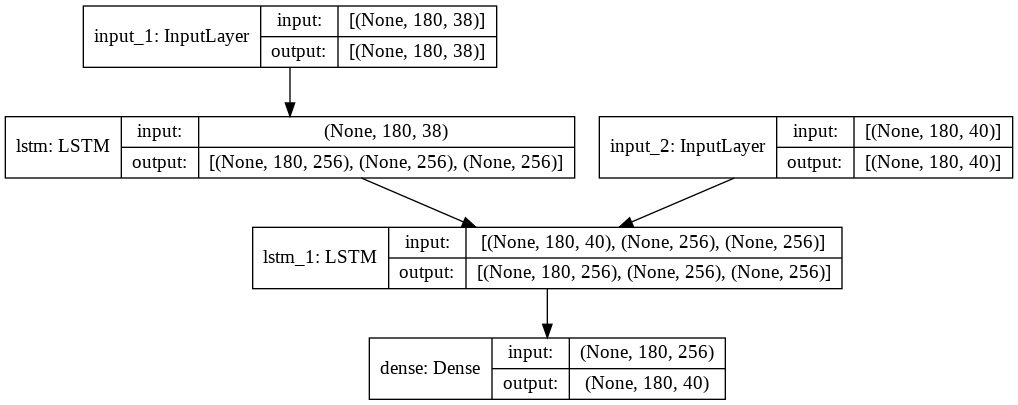

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# LOADING THE WEIGHTS FOR BEST MODEL

model.load_weights("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/char_trainable_embedding/besh.h5")

In [ ]:
## THIS FUNCTION IS USED IN THE INFERENCE TIME TO PREDICT THE RESULTS GIVEN THE INPUT TEXT

def predict(inp , model):
    ##  TAKES INPUT AS TEXT AND THE MODEL

    # CONVERT TEXT INPUT TO SEQUENCES 
    seq = tk_inp.texts_to_sequences([inp])
    # PADDING THE SEQUENCE

    seq = pad_sequences(seq,maxlen = 180,padding="post")
    ## INITIAL STATES FOR ENCODER
    state = [tf.zeros(shape=(1,256)),tf.zeros(shape= (1,256))]
    # SEQUENCE TO ONE HOT ENCODER VECORS
    enc_inp = tf.one_hot(seq , depth= (len(tk_inp.word_index)+1) , axis=-1 )
    # PASSING EMBBEDDED SEQUENCES TO LSTM LAYER
    enc_output,state_h,state_c= model.layers[2](enc_inp,state)

    # PLACE HOLDER FOR PREDECTED WORDS
    pred = []
    # PLACE HOLDER FOR STATES 
    input_state = [state_h,state_c]
    # CURRENT VECTOR TO BE PASSED TO DECODER 
    current_vec = tf.convert_to_tensor([[19]],dtype="int32")
    for i in range(180):
        ## CONVERT THE CURRENT VECTOR SEQUENCE WORD TO EMBEDDINGS
        dec_inp = tf.one_hot(current_vec , depth= (len(tk_out.word_index)+1) , axis=-1 )
         ## PASSING EMBEDDED VECTOR TO DECODER LSTM LAYER
        dec_output,dec_state_h,dec_state_c = model.layers[3](dec_inp , input_state)
        # PASSING DECODER OUTPUT TO DENSE LAYER
        dense = model.layers[4](dec_output)
        # SELECTING INDEX OF MAXIMUM DENSE OUTPUT AS CURRENT VECTOR
        current_vec = np.argmax(dense ,axis = -1)
        # UPDATING THE INPUT STATES
        input_state = [dec_state_h,dec_state_c]
        # APPENDING THE ACTUAL TEXT TO "pred" VARIABLE
        pred.append(tk_out.index_word[current_vec[0][0]])
         ## IF THE CURRENT VECTOR IS "<end>" BREAK THE LOOP
        if tk_out.index_word[current_vec[0][0]]==">":
            break
     ## RETURN THE JOINED STRING IN LIST "pred"
    return "".join(pred)

## PREDICTIONS FOR TEST DATASET

In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[19],model))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[19])

INPUT SENTENCE ===>  one day i was in time for the final train
PREDICTED SENTENCE ===>  a tete eeetrd o hvrnwl eeetig o hvr  o maee>
ACTUAL SENTENCE ===>  one day i was just on time for the final train >


In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[50])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[50],model))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[50])

INPUT SENTENCE ===>  i found that some of my firends had been here
PREDICTED SENTENCE ===>  ihvenwdig o hapyoe adassi ada adas>
ACTUAL SENTENCE ===>  i found that some of my friends had been here >


## INFERENCE TIME

In [ ]:
%%time
predict(df_test.enc_input.values[50],model)

CPU times: user 148 ms, sys: 6.17 ms, total: 154 ms
Wall time: 143 ms


'ihvenwdig o hapyoe adassi ada adas>'

## BELU Score

In [ ]:
import nltk.translate.bleu_score as bleu

In [ ]:
# VALIDATION BELU SCORE
BLEU = []
test_data = df_val.loc[np.random.choice(df_val.index,size = 2000)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = predict(str(i.enc_input),model).split()
        act = [str(i.dec_output).split()]
        b =bleu.sentence_bleu(act,pred)
        BLEU.append(b)
    except:
        continue

2000it [09:49,  3.39it/s]


In [ ]:
print("Triain BELU Score = ",np.mean(BLEU))

Triain BELU Score =  0.313970683620896


# Model Comparison for Character level Embedding

In [ ]:
s1 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/char_trainable_embedding/besh.h5")
s2 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_trainable_embedding/besh.h5")
s3 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_w2v/besh.h5")
s4 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_ft/besh.h5")
s5 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/bidirectional_train_emb/besh.h5")
s6 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/multi_layered_word/besh.h5")
s7 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/attention_dot/besh.h5")
s8 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/attention_gernal/best.h5")
s9 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/attention_concat/best.h5")
s10 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monitonic_attention_dot/best.h5")
s11 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monotonic_attention_general/best.h5")
s12 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monotonic_attention_concat/best.h5")


In [ ]:
df_comp = pd.DataFrame()
df_comp["Model"] = ["Encoder Decoder(Char Level)","Encoder Decoder","Encoder Decoder","Encoder Decoder","Bidirectional Encoder Decoder","Multilayered Encoder Decoder","Attention Dot Model","Attention Gernal Model","Attention Concat Model","Monotonic Attention Dot Model","Monotonic Attention Gernal Model","Monotonic Attention Concat Model"]
df_comp["Embedding"] = ["One Hot Encoding","Trainable Embedding" , "Pretrained Word2Vec " ,"Fast Text","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding"]
df_comp["BLEU Score(Greedy Search)"] = [0.3139,0.4603,0.4453,0.4569,0.4509,0.4527, 0.5055,0.5545,0.5388,0.5469,0.5514,0.5348]
df_comp["BLEU Score(Beam Search)"] = ["-","-","-","-",0.4561,0.4557,0.5411,0.5324,0.5671,"-","-","-"]
df_comp["Model Size(bytes)"] = [ s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12]
df_comp["Model Parameters"] = ["616,488	","26,363,578" , "8,158,378", "8,158,378","35,018,938" ," 28,464,826","33,353,914","33,419,706","33,485,755","33,353,914","33,419,706","33,485,755"]
df_comp["Inference Time(ms)"] = [143,92.3 , 94.5 , 93.7,250,311,157,164,189,164,179,176]
df_comp

,Model,Embedding,BLEU Score(Greedy Search),BLEU Score(Beam Search),Model Size(bytes),Model Parameters,Inference Time(ms)
0,Encoder Decoder(Char Level),One Hot Encoding,0.3139,-,2487608,"616,488\t",143.0
1,Encoder Decoder,Trainable Embedding,0.4603,-,105479208,"26,363,578",92.3
2,Encoder Decoder,Pretrained Word2Vec,0.4453,-,105479208,"8,158,378",94.5
3,Encoder Decoder,Fast Text,0.4569,-,105479208,"8,158,378",93.7
4,Bidirectional Encoder Decoder,Trainable Embedding,0.4509,0.4561,140102720,"35,018,938",250.0
5,Multilayered Encoder Decoder,Trainable Embedding,0.4527,0.4557,113894256,"28,464,826",311.0
6,Attention Dot Model,Trainable Embedding,0.5055,0.5411,133440296,"33,353,914",157.0
7,Attention Gernal Model,Trainable Embedding,0.5545,0.5324,133707144,"33,419,706",164.0
8,Attention Concat Model,Trainable Embedding,0.5388,0.5671,133974584,"33,485,755",189.0
9,Monotonic Attention Dot Model,Trainable Embedding,0.5469,-,133440296,"33,353,914",164.0
